# Kaggle: Titanic
#### 10/29/2017

### inspired by:
https://www.kaggle.com/omarelgabry/a-journey-through-titanic
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [50]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 3.6.0 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
numpy 1.11.3
scipy 0.18.1
matplotlib 2.0.0
pandas 0.19.2
Mon Oct 30 21:19:01 2017 EDT

In [51]:
from __future__ import division
from datetime import datetime 
import requests
from lxml import html, etree
import json
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

#never print matching warnings
warnings.filterwarnings('ignore') 

#set how pandas displays data
pd.options.display.max_columns = 100
pd.options.display.max_rows = 35
pd.options.display.width = 120

#set to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import seaborn to draw pretty graphs
import seaborn as sns
sns.set_style('whitegrid')

### Steps to check data
- Step 1: Load data
- Step 2: Check for missing data
- Step 3: Check for outliers

#### Step 1: Load data

In [3]:
data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [10]:
data.head(5)
data.dtypes
data.isnull().sum()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Step 2: Check for outliers
Use the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

In [35]:
def detect_outliers(df, n, columns):
    
    outlier_indices = []
    
    for col in columns:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1

        step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - step) | (df[col] > Q3 + step )].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [39]:
outliers_to_drop = detect_outliers(data,1,["Age","SibSp","Parch","Fare"])
len(outliers_to_drop)
print('The  number of outliers to drop: %f' % len(outliers_to_drop))

81

The  number of outliers to drop: 81.000000


In [43]:
# View outliers
data.loc[outliers_to_drop]

# Drop outliers
data = data.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S


### Remove NAN values

In [44]:
print('NAN count of all data')
data.isnull().sum()
print('Change NAN of Age into mean\n')
data['Age'].fillna((data['Age'].mean()), inplace=True)
print('NAN count of all data')
data.isnull().sum()

NAN count of all data


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            166
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          645
Embarked         2
dtype: int64

Change NAN of Age into mean

NAN count of all data


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          645
Embarked         2
dtype: int64

### Evaluate relationship between each data type

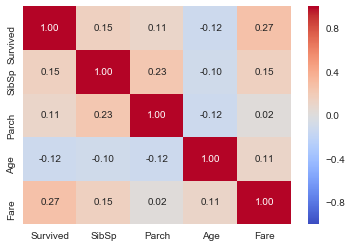

In [81]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(data[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

#### Results
- Only Fare appears to have high correlation with survival in SLM
- Note that SibSp and Parch have high correlation with each other

## Graph each data type individually

### Graph Pclass

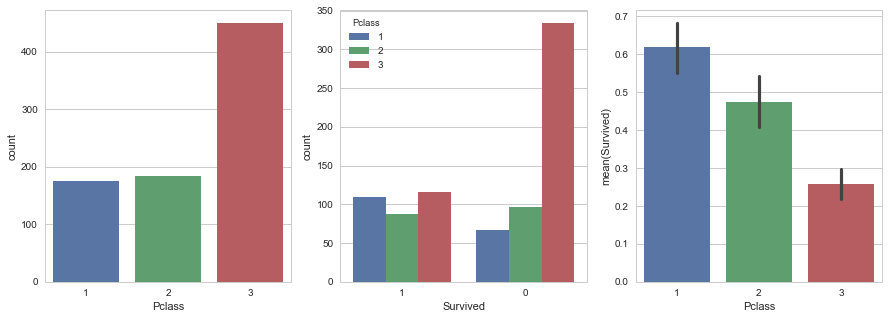

In [114]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Pclass', data=data, ax=axis1)
_=sns.countplot(x='Survived', hue="Pclass", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Pclass', y='Survived', data=data, ax=axis3)

#### Result
- class 1 has highest survival rate, class 3 has lowest survival rate

### Graph Sex

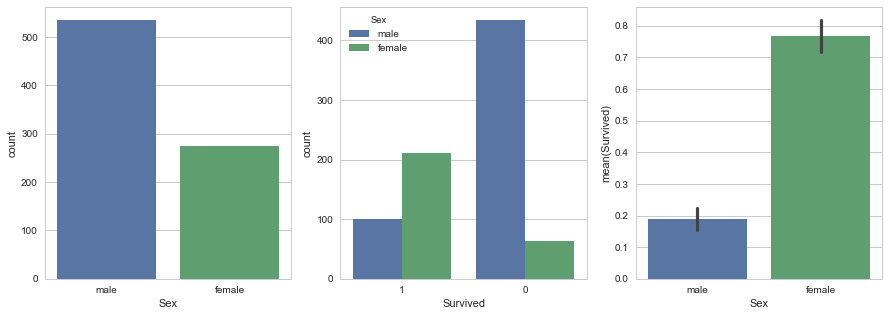

In [99]:
fig_order=['male','female']
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Sex', data=data, order=fig_order, ax=axis1)
_=sns.countplot(x='Survived', hue="Sex", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Sex', y='Survived', data=data, order=fig_order, ax=axis3)

In [120]:
from scipy import stats
data_male= data[data['Sex']=='male']
data_female= data[data['Sex']=='female']
stats.ttest_ind(data_male['Survived'], data_female['Survived'])

Ttest_indResult(statistic=-19.359833700418623, pvalue=6.8242604157761209e-69)

#### Result
- males are less likely to survive than females with pvalue <0.05

### Graph Age

In [55]:
#change survived to yes/no in the meantime
def determine_age(passenger):
    return 'adult' if passenger > 17 else 'child'
data['Age_category'] = data['Age'].apply(func=determine_age)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_category,Age_category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,no,adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,yes,adult


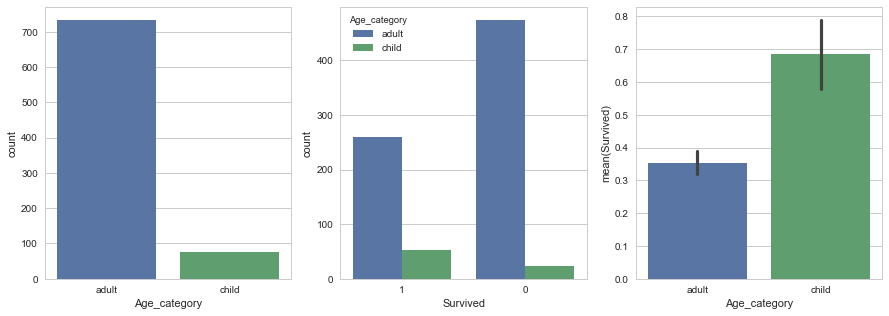

In [100]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Age_category', data=data, ax=axis1)
_=sns.countplot(x='Survived', hue="Age_category", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Age_category', y='Survived', data=data, ax=axis3)

In [121]:
#test if there is a sig different btw adult and child
from scipy import stats
data_adult= data[data['Age_category']=='adult']
data_child= data[data['Age_category']=='child']
stats.ttest_ind(data_adult['Survived'], data_child['Survived'])

Ttest_indResult(statistic=-5.7335714973272642, pvalue=1.3888802634796796e-08)

In [58]:
#fare range is 0-550
def bin_age(age):
    if age <10:
        bin4age='10y'
    if age >=10 and age <20:
        bin4age='20y'
    if age >=20 and age <30:
        bin4age='30y'
    if age >=30 and age <40:
        bin4age='40y'
    if age >=40 and age <50:
        bin4age='50y'
    if age >=50 and age <60:
        bin4age='60y'
    if age >=60 and age <70:
        bin4age='70y'
    if age >=70:
        bin4age='80y'
    return bin4age
data['Age_BIN'] = data['Age'].apply(func=bin_age)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_category,Age_category,Age_BIN
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,no,adult,30y
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,yes,adult,40y


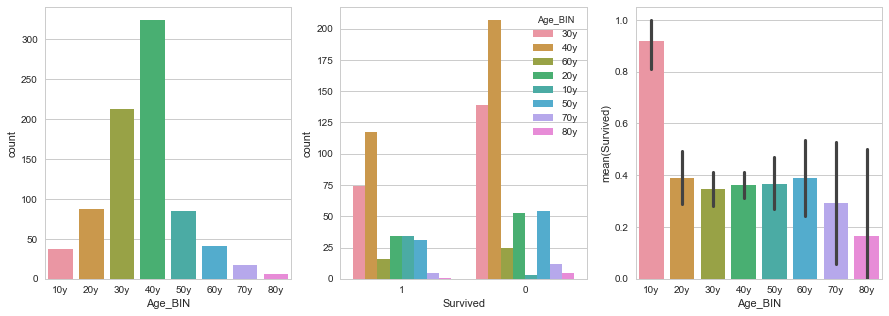

In [101]:
fig_order=['10y', '20y', '30y','40y', '50y', '60y', '70y', '80y']

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Age_BIN', data=data, order=fig_order, ax=axis1)
_=sns.countplot(x='Survived', hue="Age_BIN", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Age_BIN', y='Survived', data=data, order=fig_order, ax=axis3)

#### Result
- Children are more likely to survive than adults with pvalue < 0.05
- No difference in survival between adult ages (no relationship btw age and survival)

### Graph Siblings

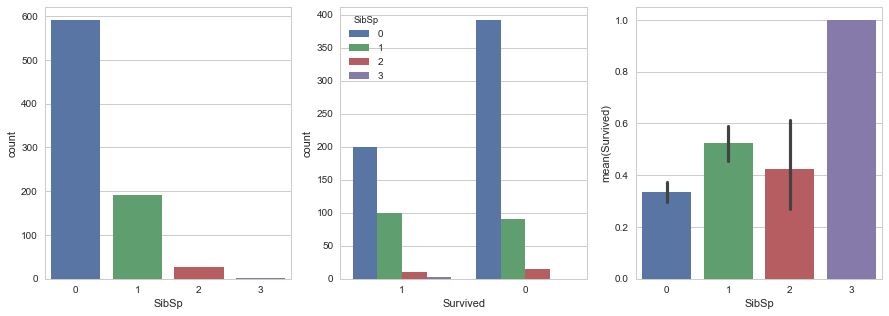

In [102]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='SibSp', data=data, ax=axis1)
_=sns.countplot(x='Survived', hue="SibSp", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='SibSp', y='Survived', data=data, ax=axis3)

In [61]:
#change survived to yes/no in the meantime
def determine_siblings(passenger):
    return 'with_siblings' if passenger > 0 else 'no_siblings'
data['Sib_category'] = data['SibSp'].apply(func=determine_siblings)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_category,Age_category,Age_BIN,Sib_category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,no,adult,30y,with_siblings
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,yes,adult,40y,with_siblings


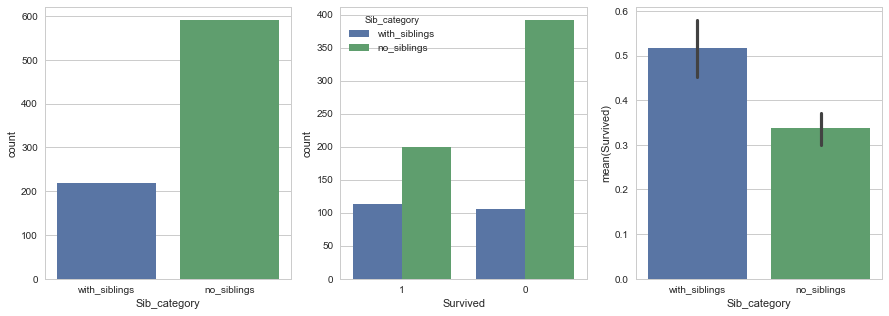

In [103]:
fig_order=['with_siblings','no_siblings']

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Sib_category', data=data, order=fig_order, ax=axis1)
_=sns.countplot(x='Survived', hue="Sib_category", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Sib_category', y='Survived', data=data, order=fig_order, ax=axis3)

### Graph parents

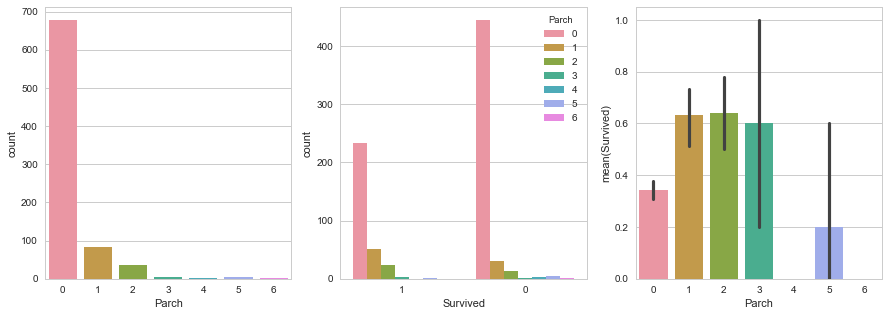

In [104]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Parch', data=data, ax=axis1)
_=sns.countplot(x='Survived', hue="Parch", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Parch', y='Survived', data=data, ax=axis3)

In [64]:
#change survived to yes/no in the meantime
def determine_parents(passenger):
    return 'with_parents' if passenger > 0 else 'no_parents'
data['Par_category'] = data['Parch'].apply(func=determine_parents)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_category,Age_category,Age_BIN,Sib_category,Par_category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,no,adult,30y,with_siblings,no_parents
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,yes,adult,40y,with_siblings,no_parents


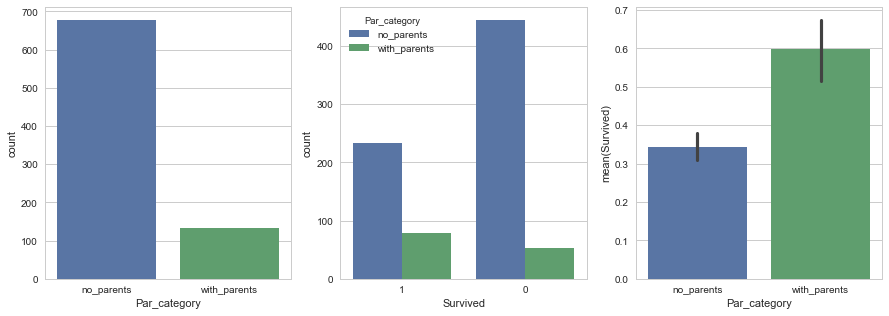

In [105]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Par_category', data=data, ax=axis1)
_=sns.countplot(x='Survived', hue="Par_category", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Par_category', y='Survived', data=data, ax=axis3)

### Graph fare

In [109]:
#fare range is 0-550
def bin_fares(fare):
    if fare <20:
        bin4fare='low'
    if fare >=20 and fare <40:
        bin4fare='mid-low'
    if fare >=40 and fare <60:
        bin4fare='mid'
    if fare >=60 and fare <80:
        bin4fare='mid-high'
    if fare >=80 and fare <100:
        bin4fare='high'
    if fare >100:
        bin4fare='highest'
    return bin4fare
data['Fare_BIN'] = data['Fare'].apply(func=bin_fares)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_category,Age_category,Age_BIN,Sib_category,Par_category,Fare_INT,Fare_BIN
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,no,adult,30y,with_siblings,no_parents,7,low
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,yes,adult,40y,with_siblings,no_parents,71,mid-high


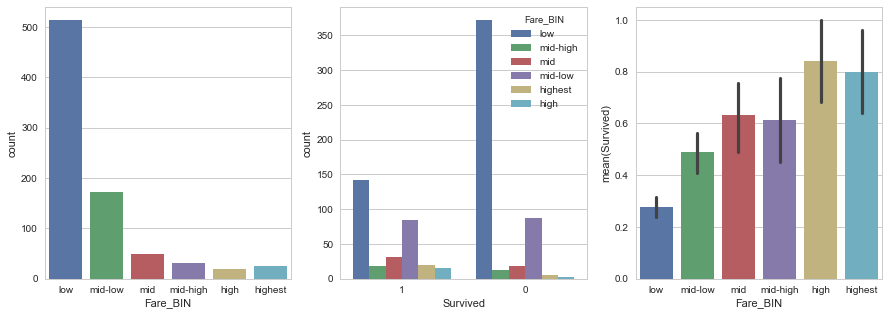

In [110]:
fig_order=['low','mid-low','mid','mid-high','high','highest']

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Fare_BIN', data=data, order=fig_order, ax=axis1)
_=sns.countplot(x='Survived', hue="Fare_BIN", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Fare_BIN', y='Survived', order=fig_order, data=data, ax=axis3)

### Graph Embarked

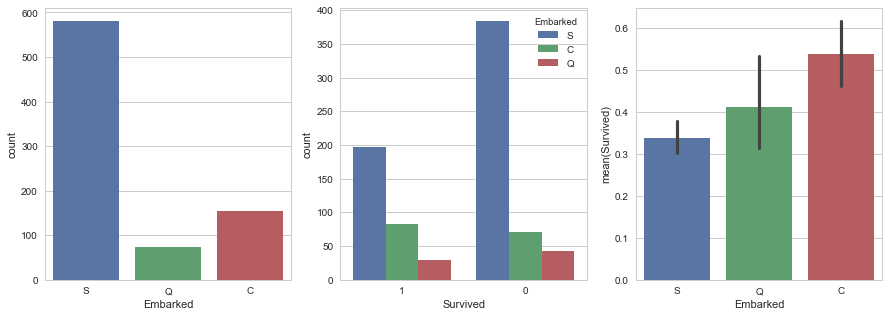

In [108]:
fig_order=['S','Q','C']

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
_=sns.countplot(x='Embarked', data=data, order=fig_order, ax=axis1)
_=sns.countplot(x='Survived', hue="Embarked", data=data, order=[1,0], ax=axis2)
_=sns.barplot(x='Embarked', y='Survived', order=fig_order, data=data, ax=axis3)

### Now create a model for all of them

#### Prep training data

In [111]:
# define training sets
X_train = data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Y_train = data["Survived"]

# view start of data
X_train.head(1)

# change categorical into separate columns to not bias the data
X_train=pd.get_dummies(X_train, columns=['Sex'])
X_train=pd.get_dummies(X_train, columns=['Embarked'])
X_train=pd.get_dummies(X_train, columns=['Pclass'])

# view start of data
X_train.head(1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.25,S


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.25,0,1,0,0,1,0,0,1


#### Prep testing data

In [112]:
# load testing data
test=pd.read_csv('test.csv')
ytest=pd.read_csv('gender_submission.csv')
test.isnull().sum()

# remove NAs
test['Age'].fillna((test['Age'].mean()), inplace=True)
test['Fare'].fillna((test['Fare'].mean()), inplace=True)
test.isnull().sum()

# prep fare value
test['Fare_INT'] = test['Fare'].apply(func=convert_fare)

# define test sets
X_test = test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Y_test = ytest["Survived"]

# view start of data
X_test.head(1)

# change sex & embarked into separate columns to not bias the data
X_test=pd.get_dummies(X_test, columns=['Sex'])
X_test=pd.get_dummies(X_test, columns=['Embarked'])
X_test=pd.get_dummies(X_test, columns=['Pclass'])

# view start of data
X_test.head(1)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,0,1,0,1,0,0,0,1


#### Run the models

In [75]:
# Don't scale the data for logistic regression
'''from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)'''

# Logistic regression
from sklearn.linear_model import LogisticRegression
_=logreg = LogisticRegression()
_=logreg.fit(X_train, Y_train)

# classification report
print('Logistic Regression score for training set: %f' % logreg.score(X_train, Y_train))
from sklearn.metrics import classification_report
y_true, y_pred = Y_test, logreg.predict(X_test)
print(classification_report(y_true, y_pred))

# calculate percent correct
Y_pred = logreg.predict(X_test)
Y_test = np.asarray(Y_test)
1-sum(abs(Y_pred-Y_test))/len(Y_pred)

# get Correlation Coefficient for each feature using Logistic Regression
'''coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])
coeff_df'''

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler().fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)'

Logistic Regression score for training set: 0.803704
             precision    recall  f1-score   support

          0       0.98      0.93      0.95       266
          1       0.89      0.97      0.92       152

avg / total       0.95      0.94      0.94       418



0.9425837320574163

'coeff_df = pd.DataFrame(X_train.columns.delete(0))\ncoeff_df.columns = [\'Features\']\ncoeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])\ncoeff_df'

In [76]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test) #need to scale test data the same way that train data was scaled

# Support Vector Regression
from sklearn.svm import SVR
regressor=SVR(kernel='rbf') #regressor is an object of the module
regressor.fit(X_train_scale, Y_train) #use train data to determine regressor
regressor.score(X_train_scale, Y_train)

#calculate percent correct
Y_pred = regressor.predict(X_test_scale)
Y_test = np.asarray(Y_test)
1-sum(abs(Y_pred-Y_test))/len(Y_pred)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

0.47212362339604685

0.7965225427937066

In [77]:
# Don't scale the data with Random Forest
'''from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)'''

# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest.score(X_train, Y_train)

#calculate percent correct
Y_pred = random_forest.predict(X_test)
Y_test = np.asarray(Y_test)
1-sum(abs(Y_pred-Y_test))/len(Y_pred)

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler().fit(X_train)\nX_train = scaler.transform(X_train)\nX_test = scaler.transform(X_test)'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

0.96172839506172836

0.81818181818181812

In [78]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

#K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scale, Y_train)
knn.score(X_train_scale, Y_train)

#calculate percent correct
Y_pred = knn.predict(X_test_scale)
Y_test = np.asarray(Y_test)
1-sum(abs(Y_pred-Y_test))/len(Y_pred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

0.87283950617283945

0.83492822966507174

In [79]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

#Gaussian NB
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train_scale, Y_train)
gaussian.score(X_train_scale, Y_train)

#calculate percent correct
Y_pred = gaussian.predict(X_test_scale)
Y_test = np.asarray(Y_test)
1-sum(abs(Y_pred-Y_test))/len(Y_pred)

GaussianNB(priors=None)

0.78024691358024689

0.90669856459330145

### Solution